## Integrate model inter-cluster with three clustering

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import copy

import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import random

from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from torch_geometric.nn import GCNConv

from utils import *
from Custom_GCNConv import Net
from Cluster_Machine import ClusteringMachine
from Cluster_Trainer import ClusterGCNTrainer_mini_Train, wholeClusterGCNTrainer_sequence

### Partition GCN

#### Check the mini clustering basic info

In [3]:
def check_clustering(clustering_machine):
    whole_graph = clustering_machine.graph

    isolate_clusters_global = [ clustering_machine.sg_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]
    
    modeling_clusters_global = [ clustering_machine.sg_model_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    validation_clusters_global = [ clustering_machine.sg_validation_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    training_clusters_global = clustering_machine.sg_train_nodes_global

    testing_clusters_global =  clustering_machine.sg_test_nodes_global

    sg_edges_clusters_global = [  clustering_machine.sg_edges_global[cluster]
                             for cluster in clustering_machine.clusters]

    print('node cluster memeber ship: ', clustering_machine.cluster_membership)
    print('isolated clusters are: ', isolate_clusters_global)
    

    print('training nodes global ids are: \n', training_clusters_global)
    
    print('testing global clusters are: ', testing_clusters_global)
    print('modeling global clusters are: ', modeling_clusters_global)
    print('validation global clusters are: ', validation_clusters_global)

    subgraphs = [clustering_machine.graph.subgraph(isolate_clusters_global[cluster]) \
                                               for cluster in clustering_machine.clusters]
    plt.subplot(231)
    nx.draw(whole_graph, with_labels=True, font_weight='bold')
    # 2) the two halves of the graph
    plt.subplot(232)
    nx.draw(subgraphs[0], with_labels=True, font_weight='bold')
    plt.subplot(233)
    nx.draw(subgraphs[1], with_labels=True, font_weight='bold')
    
    print('Info about the mini_batch only with training nodes: ')
    sg_mini_edges_clusters_global = [  clustering_machine.sg_mini_edges_global[cluster] for cluster in clustering_machine.clusters]
    sg_mini_nodes_clusters_global = clustering_machine.sg_mini_nodes_global
    print('mini train edges of each cluster, global ids: ', sg_mini_edges_clusters_global)
    print('mini train overlapping nodes global ids: ', sg_mini_nodes_clusters_global)

    mini_subgraphs = [clustering_machine.graph.subgraph(clustering_machine.accum_neighbor[cluster]) \
                                           for cluster in clustering_machine.clusters]
    plt.subplot(234)
    nx.draw(mini_subgraphs[0], with_labels=True, font_weight='bold')
    plt.subplot(235)
    nx.draw(mini_subgraphs[1], with_labels=True, font_weight='bold')



### Use Trivial data

In [ ]:

'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

check_clustering_machine = ClusteringMachine(edge_index, features, label, partition_num = 2)
check_clustering_machine.decompose(0.2, 0.4)

#### mini batch train nodes of whole graph

<font color=orange>
Note: the all_overlap and train_overlap are the same effects in the train process
    
These two differ in the validation part. Train_overlap will lose some overalpping in the validation nodes which affect F1 score

In [ ]:
# mini-batch of the all_overlap
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.mini_batch_train_clustering(2) # separate into two clusters
check_clustering(clustering_machine)


In [ ]:
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_batch.train(1, 0.0001, 0.1)
gcn_trainer_batch.validate()

#### Default whole graph (recombine train nodes)

In [ ]:
# default brute force case: recombination whole graph
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.mini_batch_train_clustering(0)      
gcn_trainer_whole = wholeClusterGCNTrainer_sequence(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_whole.train(1, 0.0001, 0.1)
gcn_trainer_whole.validate()

#### mini-batch train nodes only in the isolated cluster

In [ ]:
# mini-batch of the isolate
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_isolate_clustering(2) 
check_clustering(clustering_machine)


In [ ]:
# check_clustering(clustering_machine, True)
gcn_trainer_isolate = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16])
gcn_trainer_isolate.train(1,  0.0001, 0.1)
gcn_trainer_isolate.validate()

### Formal Test

### Use data from pytorch geometric datasets

In [4]:
local_data_root = '/media/xiangli/storage/projects/tmpdata/'
test_folder_name = 'Optimized_half_neigh/train_10%_hop_equal_net_layer/'

### Cora dataset

In [5]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[32]]

#### Checking training loss

In [ ]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.1, lr = 0.0001, weight_decay = 0.1)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

#### Output accuracy, F1, time (train, load)

Start running for partition num: 4 hop layer 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

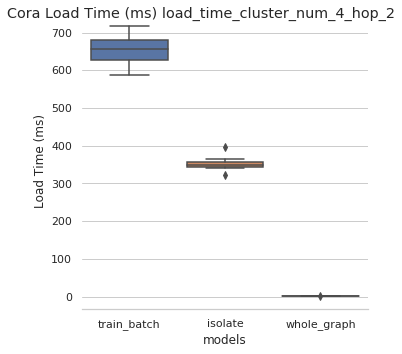

In [6]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, data_name, dataset, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.1, lr = 0.0001, weight_decay = 0.1)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### CiteSeer Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [16], [16, 16], [16, 16, 16]]

#### Checking train loss

In [ ]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.5, lr = 0.0001, weight_decay = 0.1)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

In [ ]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, data_name, dataset, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.5, lr = 0.0001, weight_decay = 0.1)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64], [64, 64, 64]]

In [ ]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.3, lr = 0.0001, weight_decay = 0.001)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

In [ ]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, data_name, dataset, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.3, lr = 0.0001, weight_decay = 0.001)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)